In [5]:
# Autoreload packages that are modified
%load_ext autoreload
%autoreload 2

import collections
from datetime import datetime, timedelta
import glob
import os
import sys
import time
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from data import get_data, dt_to_float, get_prediction_dates
from utils import plot_forecast, plot_components

cwd = os.getcwd()
sys.path.append(f"{cwd}/forecast_rodeo")
sys.path.append(f"{cwd}/forecast_rodeo/src/experiments")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get the data

In [6]:
num_forecast_steps = 7 * 4 # 28 days

X_original, anoms, clims, temps, dates, \
columnstr_to_index, index_to_columnstr = get_data(add_ones=True)
dates_as_float = np.array([dt_to_float(d) for d in dates]).astype(np.float64)

prediction_dates, prediction_dates_strs = get_prediction_dates(subsample_rate=10)
prediction_date = prediction_dates[0]
                             
# dates > 2000 should give us approximately 10 years of training data
useful_idxs = dates >= datetime(2000, 1, 1)
train_idxs = np.logical_and(dates <= prediction_date, useful_idxs)
test_idxs = np.logical_and(dates > prediction_date, useful_idxs)

# num_data_to_consider = 365 * 10 # 10 years worth of data
# assert(num_data_to_consider > num_forecast_steps)

anoms_train = anoms[train_idxs]
clims_train = clims[train_idxs]
temps_train = temps[train_idxs]
dates_train = dates[train_idxs]
dates_as_float_train = dates_as_float[train_idxs]

anoms_test = anoms[test_idxs]
clims_test = clims[test_idxs]
temps_test = temps[test_idxs]
dates_test = dates[test_idxs]
dates_as_float_test = dates_as_float[test_idxs]

print(f"Num in training set: {len(anoms_train)}")
print(f"Num in testing set: {len(anoms_test)}")

is_predicting_anomaly = False
if is_predicting_anomaly:
    Y_train = anoms_train#.astype(np.float64)
    Y_test = anoms_test#.astype(np.float64)
    print(f"Y is temperature anomaly!")
else:
    Y_train = temps_train#.astype(np.float64)
    Y_test = temps_test#.astype(np.float64)
    print(f"Y is temperature directly!")


['forecast_rodeo/results/regression/shared/contest_tmp2m_34w/lat_lon_date_data-contest_tmp2m_34w.h5', 'forecast_rodeo/results/regression/shared/contest_tmp2m_34w/date_data-contest_tmp2m_34w.h5']
lat_oi: 42.0, lon_oi: 251.0
Num in training set: 4123
Num in testing set: 2590
Y is temperature directly!


In [8]:
normalize_features = True
X_normalized = np.copy(X_original)
if normalize_features:
    for col_idx in range(X_original.shape[1]):
        if index_to_columnstr[col_idx] == 'ones':
            X_normalized[:, col_idx] = X_original[:, col_idx]
            continue
        vals = X_original[:, col_idx]
        mean = np.mean(X_original[:, col_idx])        
        std = np.std(X_original[:, col_idx])
        X_normalized[:, col_idx] = (vals - mean) / std

X = X_normalized[useful_idxs, :]
X_train = X_normalized[train_idxs, :]
X_test = X_normalized[test_idxs, :]


(4123,)


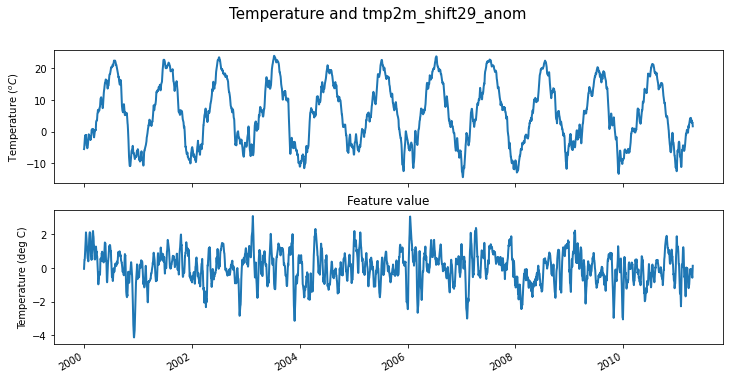

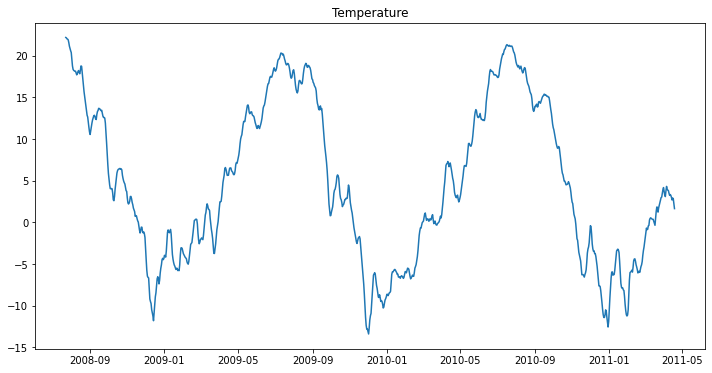

In [11]:
print(Y_train.shape)

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dates_train,
        Y_train, lw=2, label="training data")
ax.set_ylabel("Temperature ($^oC$)")

ax = fig.add_subplot(2, 1, 2)

feature_str = "tmp2m_shift29_anom"
ax.plot(dates_train,
        X_train[:, columnstr_to_index[feature_str]], lw=2, label="training data")
ax.set_ylabel("Temperature Anomaly (deg C)" if is_predicting_anomaly else "Temperature (deg C)")
ax.set_title("Feature value")
fig.suptitle(f"Temperature Anomaly and {feature_str}" if is_predicting_anomaly else 
             f"Temperature and {feature_str}",
             fontsize=15)
fig.autofmt_xdate()

plt.figure(figsize=(12, 6))
plt.title(f"Temperature Anomaly" if is_predicting_anomaly else f"Temperature")
plt.plot(dates_train[-1000:], Y_train[-1000:])


In [12]:
def build_model(observed_time_series):
    annual = tfp.sts.SmoothSeasonal(
        period=365,
        frequency_multipliers=[1, 2, 4, 12],
        initial_state_prior=tfd.MultivariateNormalDiag(scale_diag=tf.ones([8])),
        observed_time_series=observed_time_series,
        name='annual'
    )
    features_effects = []
    # features_effects.append(
    #     tfp.sts.LinearRegression(
    #         design_matrix=X,# - np.mean(X),
    #         name=f"linear_regression"
    #     )
    # )
    for feature_name, idx in columnstr_to_index.items():
        features_effects.append(
            tfp.sts.LinearRegression(
                design_matrix=np.expand_dims(X[:, idx], 1),# - np.mean(X),
                name=f"lr_{feature_name}_{idx}"
            )
        )
    sts_components = [
        annual,
    ] + features_effects
    model = tfp.sts.Sum(
        sts_components,
        observed_time_series=observed_time_series
    )
    return model

temperature_model = build_model(Y_train)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=temperature_model)


In [13]:
num_variational_steps = 80
optimizer = tf.optimizers.Adam(learning_rate=.1)

# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=temperature_model.joint_log_prob(
            observed_time_series=Y_train),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps)
    return elbo_loss_curve

start = time.time()
elbo_loss_curve = train()
end = time.time()
print(f"{end - start} seconds for training")


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Do not call `graph_parents`.
281.45900654792786 seconds for training


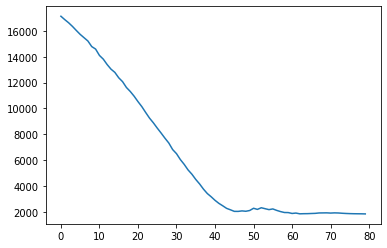

tf.Tensor(
[17129.     16867.086  16624.357  16342.15   16028.834  15727.383
 15471.198  15216.657  14784.296  14592.322  14100.072  13812.105
 13394.57   13039.123  12790.148  12374.065  12073.863  11623.557
 11314.087  10949.479  10531.649  10143.771   9690.909   9254.262
  8890.505   8486.265   8103.6523  7704.6035  7331.7266  6824.432
  6507.6636  6051.9897  5679.431   5251.0977  4919.4834  4515.2334
  4166.8354  3766.5615  3425.7114  3175.7559  2900.5781  2666.8635
  2479.422   2281.351   2169.0974  2048.9404  2046.0997  2084.413
  2056.214   2114.5693  2287.7983  2200.8162  2327.6072  2254.4607
  2182.3833  2236.3547  2124.3372  2031.8606  1960.5779  1954.4524
  1887.2046  1916.808   1858.6768  1868.5612  1871.6823  1884.0625
  1894.4219  1924.865   1929.0742  1933.4675  1916.6816  1931.7701
  1923.5864  1901.9269  1885.5682  1873.6118  1866.3029  1861.8752
  1858.9722  1851.2655], shape=(80,), dtype=float32)


In [14]:
plt.plot(elbo_loss_curve)
plt.show()
print(elbo_loss_curve)

In [16]:
# Draw samples from the variational posterior.
q_samples_temperature_ = variational_posteriors.sample(25)


print("Inferred parameters:")
for param in temperature_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_temperature_[param.name], axis=0),
                              np.std(q_samples_temperature_[param.name], axis=0)))


Inferred parameters:
observation_noise_scale: 0.020181113854050636 +- 0.0004174216592218727
annual/_drift_scale: 0.16852053999900818 +- 0.0012141538318246603
lr_ones_0/_weights: [0.05277529] +- [0.18777005]
lr_tmp2m_shift29_1/_weights: [-0.03470882] +- [0.133689]
lr_tmp2m_shift29_anom_2/_weights: [-0.33155513] +- [0.0347423]
lr_tmp2m_shift58_3/_weights: [0.2463003] +- [0.16875596]
lr_tmp2m_shift58_anom_4/_weights: [-0.0131569] +- [0.03121023]
lr_rhum_shift30_5/_weights: [0.02607545] +- [0.12343331]
lr_pres_shift30_6/_weights: [0.03651544] +- [0.04523253]
lr_nmme_wo_ccsm3_nasa_7/_weights: [0.04093344] +- [0.11499327]
lr_nmme0_wo_ccsm3_nasa_8/_weights: [0.00621452] +- [0.05047619]
lr_mei_shift45_9/_weights: [-0.08038254] +- [0.07712987]
lr_phase_shift17_10/_weights: [-0.01494354] +- [0.00790979]
lr_sst_2010_1_shift30_11/_weights: [-0.5110728] +- [0.8628563]
lr_sst_2010_2_shift30_12/_weights: [-0.93167084] +- [0.36234897]
lr_sst_2010_3_shift30_13/_weights: [0.8348738] +- [0.26406944]
lr_i

## Forecasting

In [17]:
start = time.time()
temperature_forecast_dist = tfp.sts.forecast(
    model=temperature_model,
    observed_time_series=Y_train,
    parameter_samples=q_samples_temperature_,
    num_steps_forecast=num_forecast_steps)
end = time.time()
print(f"time elapsed = {end - start}")

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
time elapsed = 604.3435299396515


ValueError: operands could not be broadcast together with shapes (28,) (2590,) 

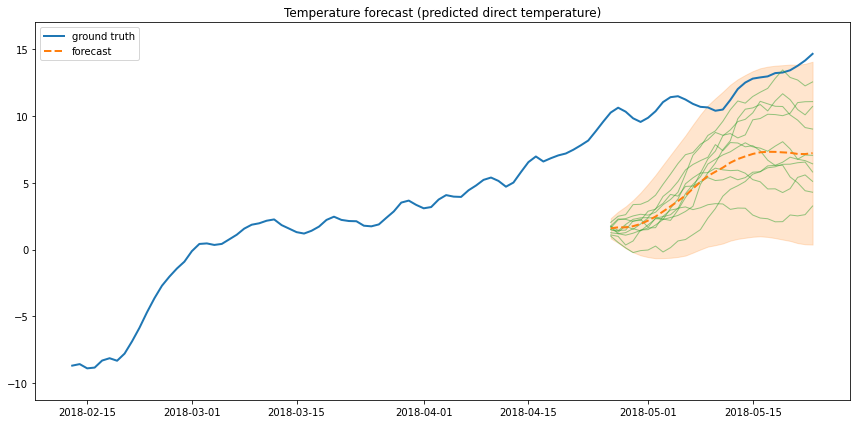

In [18]:
num_samples=10
plot_num = 100

(
    temperature_forecast_mean,
    temperature_forecast_scale,
    temperature_forecast_samples
) = (
    temperature_forecast_dist.mean().numpy()[..., 0],
    temperature_forecast_dist.stddev().numpy()[..., 0],
    temperature_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

if is_predicting_anomaly:
    fig, ax = plot_forecast(dates, anoms + clims,
                            temperature_forecast_mean + clims_test,
                            temperature_forecast_scale,
                            temperature_forecast_samples + clims_test,
                            title="Temperature forecast (predicted anomaly)",
                            plot_num=plot_num,
    )
    fig.tight_layout()
    fig, ax = plot_forecast(dates, anoms,
                            temperature_forecast_mean,
                            temperature_forecast_scale,
                            temperature_forecast_samples,
                            title="Anomaly forecast (predicted anomaly)",
                            plot_num=plot_num,
    )
    fig.tight_layout()

    
    anoms_hat = temperature_forecast_mean[14:]
    anoms_hat_norm = anoms_hat / np.linalg.norm(anoms_hat)
    anoms_test_norm = anoms_test[14:] / np.linalg.norm(anoms_test[14:])
    print(f"skill: {anoms_hat_norm.dot(anoms_test_norm)}")

    
else:
    fig, ax = plot_forecast(dates, temps,
                            temperature_forecast_mean,
                            temperature_forecast_scale,
                            temperature_forecast_samples,
                            title="Temperature forecast (predicted direct temperature)",
                            plot_num=plot_num,
    )
    fig.tight_layout()

    fig, ax = plot_forecast(dates, anoms,
                        temperature_forecast_mean - clims_test,
                        temperature_forecast_scale,
                        temperature_forecast_samples - clims_test,
                        title="Anomaly forecast (predicted direct temperature)",
                        plot_num=plot_num,
    )
    fig.tight_layout()
    
    
    anoms_hat = temperature_forecast_mean[14:] - clims_test[14:]
    anoms_hat_norm = anoms_hat / np.linalg.norm(anoms_hat)
    anoms_test_norm = anoms_test[14:] / np.linalg.norm(anoms_test[14:])
    print(f"skill: {anoms_hat_norm.dot(anoms_test_norm)}")



In [ ]:
num_to_plot_for_decomp = 10 * 365
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = tfp.sts.decompose_by_component(
    temperature_model,
    observed_time_series=Y_train[-num_to_plot_for_decomp:],
    parameter_samples=q_samples_temperature_
)

forecast_component_dists = tfp.sts.decompose_forecast_by_component(
    temperature_model,
    forecast_dist=temperature_forecast_dist,
    parameter_samples=q_samples_temperature_
)


temperature_component_means_, temperature_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

temperature_forecast_component_means_, temperature_forecast_component_stddevs_ = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
)


In [ ]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
    
for k in temperature_component_means_.keys():
    component_with_forecast_means_[k] = np.concatenate([
        temperature_component_means_[k],
        temperature_forecast_component_means_[k]
    ], axis=-1)
    component_with_forecast_stddevs_[k] = np.concatenate([
        temperature_component_stddevs_[k],
        temperature_forecast_component_stddevs_[k]
    ], axis=-1)

fig, axes = plot_components(
    dates[-num_to_plot_for_decomp:],
    component_with_forecast_means_,
    component_with_forecast_stddevs_,
    vals_to_plot = num_to_plot_for_decomp
)
for ax in axes.values():
  ax.axvline(dates[-num_forecast_steps], linestyle="--", color='red')
